# Logistic Regression
Logistic Regression (aka logit, MaxEnt) classifier.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    precision_score, recall_score, roc_auc_score, 
    classification_report, confusion_matrix
)

sns.set()
plt.rcParams["figure.figsize"] = (10, 4)

## Sample Data

- Not linearly separable sample data
- 

In [2]:
n_samples = 3000
n_features = 2
class_sep = .6 #hihger value makes the class more distinct to each other
data_X, data_y = make_classification(
    n_samples=n_samples, n_features=n_features, n_redundant=0, 
    n_informative=2, class_sep=class_sep, n_classes=2, shuffle=True, 
    random_state=42
)
print(data_X.shape, data_y.shape)

(3000, 2) (3000,)


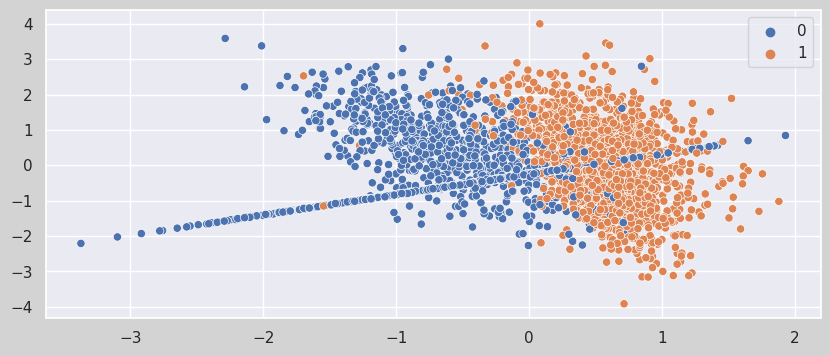

In [3]:
plt.figure(facecolor='lightgray')
sns.scatterplot(x=data_X[:, 0], y=data_X[:, 1], hue=data_y)
# plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, marker='o', 
#             edgecolors='k', cmap=plt.cm.spring)
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y, test_size=0.2,random_state=714)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2400, 2) (600, 2) (2400,) (600,)


## Modelling with Logistic Regression

### LogisticRegression

In [5]:
log_sk = LogisticRegression(solver='lbfgs')
log_sk.fit(X_train, y_train)
tmp = log_sk.score(X_test, y_test)

print('Base Accuracy: ', tmp)

Base Accuracy:  0.91


In [6]:
tmp = roc_auc_score(y_true=y_test, y_score=log_sk.predict(X_test))

print('Base ROC AUC: ', tmp)

Base ROC AUC:  0.9111182755055529


#### Compare with Linear Regression
1. Classification problem cannot be modelled well by linear regression
    + x-axis as the linear combination of all predictors (x)
    + y-axis as the lable/class
    + regression line is taking the mean of each class
2. Shape of probability is more s-shape, not linear shape
    + x-axis as the linear combination of all predictors (x)
    + y-axis as the predicted proability of logistic regression 

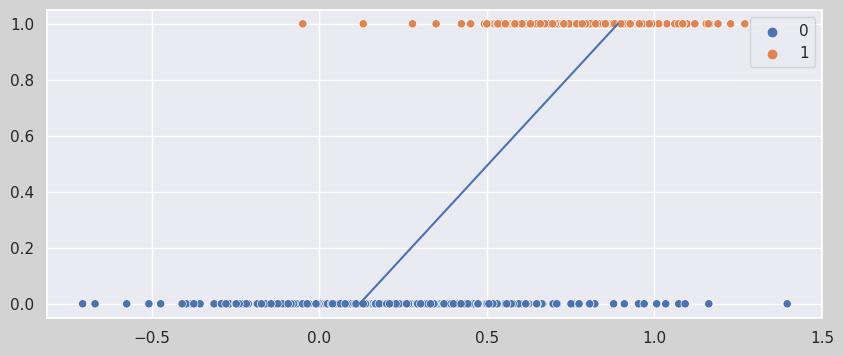

In [7]:
lr_sk = LinearRegression()
lr_sk.fit(X_train, y_train)

# result from linear regression
tmp = np.c_[lr_sk.predict(X_test), y_test]

plt.figure(facecolor='lightgray')

sns.scatterplot(x=lr_sk.predict(X_test), y=y_test, hue=y_test)
sns.lineplot(x=(tmp[tmp[:, 1] == 0].mean(), tmp[tmp[:, 1] == 1].mean()), y=(0, 1))
plt.show()
# not predicted well by linear regression

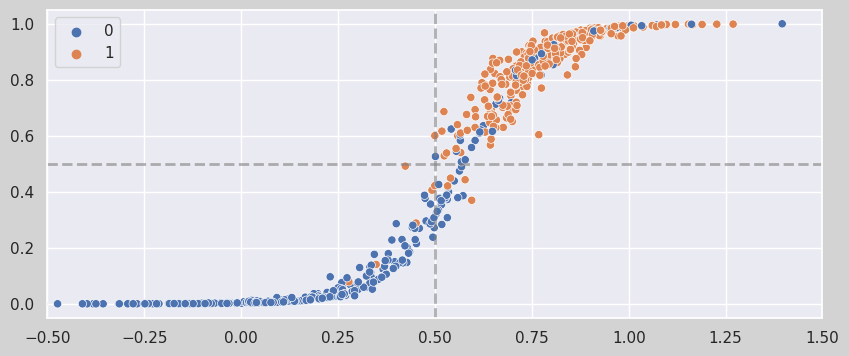

In [8]:
plt.figure(facecolor='lightgray')

# results from logistic regression
sns.scatterplot(x=lr_sk.predict(X_test), y=log_sk.predict_proba(X_test)[:, 1], hue=y_test)
plt.axhline(y=0.5, linewidth=2, color='grey', linestyle='--', alpha=0.6)
plt.axvline(x=0.5, linewidth=2, color='grey', linestyle='--', alpha=0.6)
plt.xlim(-.5, 1.5)
plt.show()
# not linear shape, but more s-shape

### Gradient Descent

In [9]:
# adding ones to X_train, with 1 at first column 
X_train_ones = np.c_[np.ones((len(X_train), 1)), X_train]
X_test_ones = np.c_[np.ones((len(X_test), 1)), X_test]

X_train_ones.shape, X_test_ones.shape

((2400, 3), (600, 3))

#### Link Function for Logistic Regression 
logistic function, inverse of logit function.

In [10]:
# sigmoid function, more precisely called logistic function
# reconstuct probability from log-odds, see 'Prob_odds_log-odds.pdf'
def sigmoid_fun(z):
    return 1 / (1 + np.exp(-z))

#### Optimization Methods
https://en.wikipedia.org/wiki/Logistic_regression#Model_fitting  


+ Minimize Cost/ Error
    + by computing the cost/error function
+ Maximize Likelihood/ Log-likelihood/ Average log-likelihood
    + by computing the likelihood on each estimate  

https://stats.stackexchange.com/questions/182746/maximizing-likelihood-vs-minimizing-cost  

In [11]:
# Log-Likelihood function
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

In [12]:
# define/initialize variable
learning_rate = 0.005
num_iter = 50000 # number of iterations
# theta = np.zeros(X_train_ones.shape[1])
theta = np.random.normal(size=X_train_ones.shape[1]) 

In [13]:
%%time
for iteration in range(num_iter):
    # Multiplication of training data and weights, linear combination of training data
    # get log-odds, or logits from linear regression; logit transformation
    z = np.matmul(X_train_ones, theta) 
    # Hypothesis function, return the predictions (of probability)
    # from log-odds/logits to compute probability
    hx = sigmoid_fun(z)
    # Use average log-likelhood for gradient
#     gradient = np.dot(X_train_ones.T, (hx - y_train)) / y_train.size
    # Use log-likelihood for gradient
    gradient = np.dot(X_train_ones.T, (hx - y_train))
    # Update the weights at this step
    updated_theta = theta - learning_rate * gradient
    
    if(iteration % 10000 == 0):
        # cost function J(θ), the goal is to minimize the cost/loss
        J_theta_loss = (1 / len(X_train_ones)) * sum(-y_train * np.log(hx) - (1 - y_train) * np.log(1 - hx))
#         J_theta_loss = (-y_train * np.log(hx) - (1 - y_train) * np.log(1 - hx)).mean()
        # log likelihood function, the goal is to maxmize likelihood
        ll = log_likelihood(X_train_ones, y_train, updated_theta)
        
        print('At {} iteration:'.format(iteration))
        print('J(θ) loss: {} \t ;Log Likelihood: {}'.format(J_theta_loss, ll))
        print('--')
    # Update the weights
    theta = updated_theta
print('Done')

At 0 iteration:
J(θ) loss: 0.4152012935027078 	 ;Log Likelihood: -790.2366369167025
--
At 10000 iteration:
J(θ) loss: 0.28522138188766755 	 ;Log Likelihood: -684.5313165304021
--
At 20000 iteration:
J(θ) loss: 0.28522138188766755 	 ;Log Likelihood: -684.5313165304021
--
At 30000 iteration:
J(θ) loss: 0.28522138188766755 	 ;Log Likelihood: -684.5313165304021
--
At 40000 iteration:
J(θ) loss: 0.28522138188766755 	 ;Log Likelihood: -684.5313165304021
--
Done
CPU times: user 1.96 s, sys: 1.6 ms, total: 1.97 s
Wall time: 1.96 s


In [14]:
# compare with results from sklearn
df_res = pd.DataFrame(data=dict(intercept=[log_sk.intercept_[0], theta[0]], 
                    coef_1=[log_sk.coef_[0][0], theta[1]], 
                    coef_2=[log_sk.coef_[0][1], theta[2]]), 
         index=['sklearn', 'numpy']).round(decimals=5)
df_res

,intercept,coef_1,coef_2
sklearn,-0.52712,4.59499,0.59717
numpy,-0.56428,4.77055,0.62946


#### Plot the resutls

In [15]:
xx, yy = np.meshgrid(np.arange(-3, 3, 0.01), # x range
                     np.arange(-4, 4, 0.01)) # y range
grid = np.c_[xx.ravel(), yy.ravel()] # concatenate numpy matrix by column

In [16]:
# add ones to grid
grid_ones = np.c_[np.ones((len(grid), 1)), grid]

# compute probability of class 
probs = (sigmoid_fun(np.matmul(grid_ones, theta))).reshape(xx.shape)
print(probs.shape)

(800, 600)


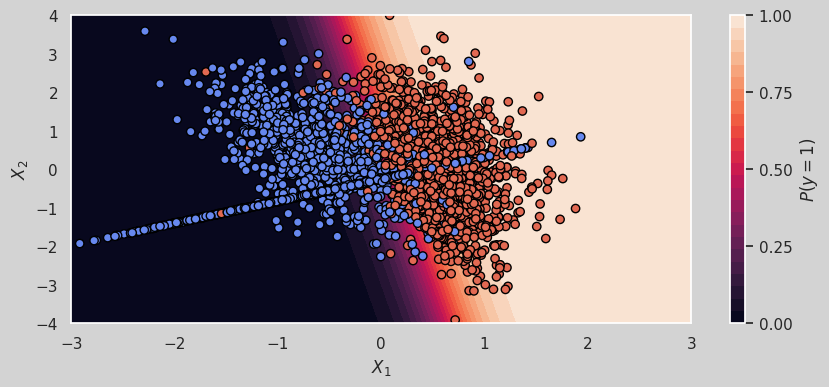

In [17]:
f, ax = plt.subplots(facecolor='lightgray')

# draw a color bar
# contour = ax.contourf(xx, yy, probs, 25, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
contour = ax.contourf(xx, yy, probs, 25, vmin=0, vmax=1)
ax_c = f.colorbar(contour) 

# draw label and ticks
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# setup plot area 
ax.set(aspect="auto", xlim=(-3, 3), ylim=(-4, 4), # limit of plot area
       xlabel="$X_1$", ylabel="$X_2$")

# main scatter plot
ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y, marker='o', cmap=plt.cm.coolwarm,  
           vmin=-0.2, vmax=1.2, edgecolor="black", linewidth=1) 

plt.show()

### Python Class

In [18]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if(self.verbose == True and i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print('loss: {} \t'.format(self.__loss(h, y)))
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [19]:
model = LogisticRegression(lr=0.005, num_iter=30000, verbose=True)

In [20]:
%time model.fit(X_train, y_train)

loss: 0.692691636836778 	
loss: 0.29947985611494976 	
loss: 0.28850738124549885 	
CPU times: user 2.35 s, sys: 53.8 ms, total: 2.4 s
Wall time: 2.4 s


In [21]:
preds = model.predict(X_test, threshold=0.5)
(preds == y_test).mean()

0.91

### Regularizations

- https://gist.github.com/kevindavenport/c524268ed0713371aa32#file-regularized_logistic_regression_intuition-ipynb